# Pangeo Vorticity Workload

This is a notebook for exploring a simplified version of the example in https://github.com/pangeo-data/distributed-array-examples/issues/1.

See also Tom Nicholas's [notebook](https://gist.github.com/TomNicholas/8366c917349b647d87860a20a257a3fb#file-benchmark-vorticity-ipynb) exploring this problem. Note that the code below for `diff` is based on the Dask version.

In [1]:
import cubed
import cubed.random
from cubed.extensions.rich import RichProgressBar
import xarray as xr

Initialization parameters for the workload

In [2]:
t_length = 50
spec = cubed.Spec(allowed_mem="2GB")

Create random data stored in Zarr.

In [3]:
u = cubed.random.random((t_length, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec)
v = cubed.random.random((t_length, 1, 987, 1920), chunks=(10, 1, -1, -1), spec=spec)
dx = cubed.random.random((1, 987, 1920), chunks=(1, -1, -1), spec=spec)
dy = cubed.random.random((1, 987, 1920), chunks=(1, -1, -1), spec=spec)
arrays = [u, v, dx, dy]
paths = [
    f"{spec.work_dir}/u_{t_length}.zarr",
    f"{spec.work_dir}/v_{t_length}.zarr",
    f"{spec.work_dir}/dx_{t_length}.zarr",
    f"{spec.work_dir}/dy_{t_length}.zarr",
]
cubed.store(arrays, paths, compute_arrays_in_parallel=True, callbacks=[RichProgressBar()])

Output()

In [4]:
u = cubed.from_zarr(paths[0], spec=spec)
v = cubed.from_zarr(paths[1], spec=spec)
dx = cubed.from_zarr(paths[2], spec=spec)
dy = cubed.from_zarr(paths[3], spec=spec)
ds = xr.Dataset(
    dict(
        U=(["time", "face", "j", "i"], u),
        V=(["time", "face", "j", "i"], v),
        dx=(["face", "j", "i"], dx),
        dy=(["face", "j", "i"], dy),
    )
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:  (time: 50, face: 1, j: 987, i: 1920)
Dimensions without coordinates: time, face, j, i
Data variables:
    U        (time, face, j, i) float64 758MB cubed.Array<chunksize=(10, 1, 987, 1920)>
    V        (time, face, j, i) float64 758MB cubed.Array<chunksize=(10, 1, 987, 1920)>
    dx       (face, j, i) float64 15MB cubed.Array<chunksize=(1, 987, 1920)>
    dy       (face, j, i) float64 15MB cubed.Array<chunksize=(1, 987, 1920)>

In [5]:
def diff(da, dim):
    """
    First order derivative along dim.
    
    Differencing removes one grid element, so pad to restore size.
    """
    # Once https://github.com/cubed-dev/cubed/issues/475 is done we can use this simpler implmentation:
    # return da.diff(dim).pad({dim: (1, 0)}, mode='symmetric')
    
    ind = da.dims.index(dim)
    d = da.diff(dim).data
    pad_width = tuple((0, 0) if i != ind else (1, 0) for i in range(da.ndim))
    chunks = da.data.chunks # make sure result after padding has original chunk size
    p = cubed.pad(d, pad_width=pad_width, mode="symmetric", chunks=chunks)
    return xr.DataArray(p, dims=da.dims)

In [6]:
omega = diff(ds.U, dim='j') * ds.dx - diff(ds.V, dim='i') * ds.dy
mean = omega.mean('time', skipna=False)
mean

<xarray.DataArray (face: 1, j: 987, i: 1920)> Size: 15MB
cubed.Array<array-061, shape=(1, 987, 1920), dtype=float64, chunks=((1,), (987,), (1920,))>
Dimensions without coordinates: face, j, i

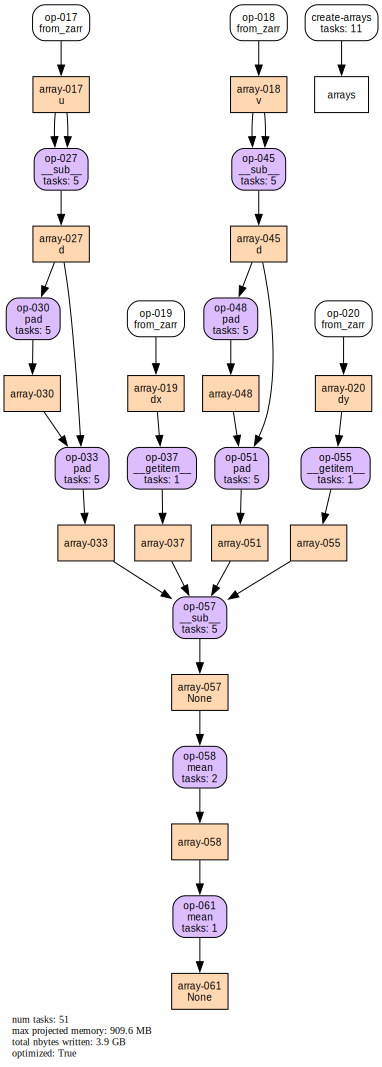

In [7]:
mean.data.visualize()

In [8]:
mean.compute(callbacks=[RichProgressBar()])

Output()

<xarray.DataArray (face: 1, j: 987, i: 1920)> Size: 15MB
array([[[-0.00935039,  0.05180967,  0.02368589, ...,  0.09296773,
         -0.02251309,  0.00811106],
        [-0.03833913,  0.05900023,  0.01459681, ..., -0.01437545,
          0.01901828,  0.02181335],
        [ 0.00342973,  0.01948303,  0.01160908, ...,  0.02988825,
         -0.0061075 , -0.01061161],
        ...,
        [ 0.03900664,  0.04362473,  0.00623131, ..., -0.03877337,
          0.00551559, -0.0664945 ],
        [-0.01084767, -0.00746532,  0.04994078, ...,  0.00983424,
         -0.00747178, -0.01885188],
        [ 0.00544092,  0.05520928, -0.0255991 , ...,  0.02842916,
          0.0289831 ,  0.01773723]]])
Dimensions without coordinates: face, j, i

## A more efficient implementation

In the above visualization we can see that the `diff` and `pad` operations are not fused together. This is something that could be improved in the future; see [#464](https://github.com/cubed-dev/cubed/issues/464) for what is needed.

In the meantime, we can use Cubed's `map_overlap` to write a more efficient combined version of `diff` and `pad`, called `diff_pad`.

In [9]:
from cubed.backend_array_api import namespace as nxp
from cubed.overlap import map_overlap
from cubed.vendor.dask.array.utils import validate_axis

In [10]:
def diff_pad(x, /, *, axis=-1):
    axis = validate_axis(axis, x.ndim)
    depth = tuple(1 if i == axis else 0 for i in range(x.ndim))
    return map_overlap(
        _diff_pad,
        x,
        dtype=x.dtype,
        chunks=x.chunks,
        depth=depth,
        boundary=0,  # actual value is ignored
        trim=False,
        axis=axis,
    )


def _diff_pad(a, block_id=None, axis=None):
    if block_id[axis] == 0:  # pad first block along axis
        sl = tuple(slice(1, -1) if i == axis else slice(None) for i in range(a.ndim))
        val = nxp.diff(a[sl], axis=axis)
        pad_width = tuple((1, 0) if i == axis else (0, 0) for i in range(a.ndim))
        val = nxp.pad(val, pad_width=pad_width, mode="symmetric")
        return val
    else:
        sl = tuple(slice(None, -1) if i == axis else slice(None) for i in range(a.ndim))
        return nxp.diff(a[sl], axis=axis)

Now we can write a more efficient version of `diff` from above

In [11]:
def diff2(da, dim):
    ind = da.dims.index(dim)
    dp = diff_pad(da.data, axis=ind)
    return xr.DataArray(dp, dims=da.dims)

In [12]:
omega = diff2(ds.U, dim='j') * ds.dx - diff2(ds.V, dim='i') * ds.dy
mean = omega.mean('time', skipna=False)
mean

<xarray.DataArray (face: 1, j: 987, i: 1920)> Size: 15MB
cubed.Array<array-082, shape=(1, 987, 1920), dtype=float64, chunks=((1,), (987,), (1920,))>
Dimensions without coordinates: face, j, i

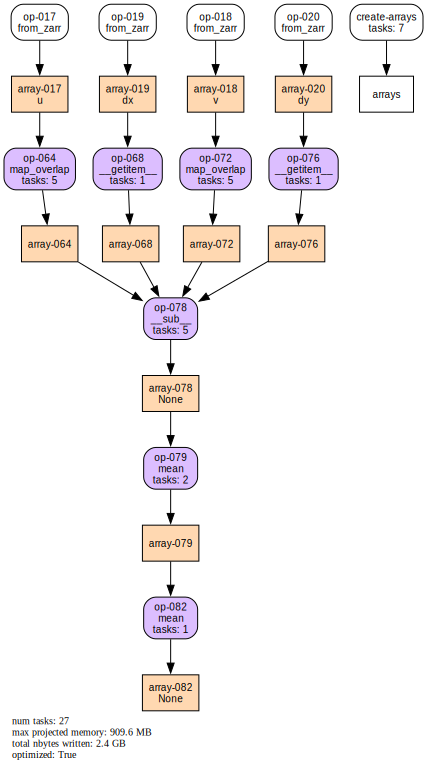

In [13]:
mean.data.visualize()

In [14]:
mean.compute(callbacks=[RichProgressBar()])

Output()

<xarray.DataArray (face: 1, j: 987, i: 1920)> Size: 15MB
array([[[-0.00935039,  0.05180967,  0.02368589, ...,  0.09296773,
         -0.02251309,  0.00811106],
        [-0.03833913,  0.05900023,  0.01459681, ..., -0.01437545,
          0.01901828,  0.02181335],
        [ 0.00342973,  0.01948303,  0.01160908, ...,  0.02988825,
         -0.0061075 , -0.01061161],
        ...,
        [ 0.03900664,  0.04362473,  0.00623131, ..., -0.03877337,
          0.00551559, -0.0664945 ],
        [-0.01084767, -0.00746532,  0.04994078, ...,  0.00983424,
         -0.00747178, -0.01885188],
        [ 0.00544092,  0.05520928, -0.0255991 , ...,  0.02842916,
          0.0289831 ,  0.01773723]]])
Dimensions without coordinates: face, j, i